In [15]:
import pandas as pd
from dateutil import parser

In [16]:
# Function to convert date string to datetime
def date_str_to_datetime(date_str):
    try: 
        return parser.parse(date_str)
    except:
        return -1

# Function to parse the subjects from the text to list
def extract_subjects(text):
    try:
        # Find the part of the text starting with 'Subject: '
        subject_part = text.split('Subject:\xa0')[1]
        # Find the first occurrence of "\n\n" and split there
        end_index = subject_part.find('\n\n')
        if end_index != -1:
            subject_part = subject_part[:end_index]
        # Remove content inside parentheses and parentheses themselves
        clean_subjects = ''.join([i for i in subject_part if not i.isdigit() and i not in '()%'])
        # Split by ';' and strip whitespace
        subject_list = [subject.strip() for subject in clean_subjects.split(';') if subject.strip()]
    except (IndexError, ValueError):
        # Return an empty list if there's an issue with the text format
        subject_list = []
    return subject_list

# Find the set of unique subject
def get_unique_subjects(df):
    subjects = []
    for subject_list in df['subject']:
        subjects.extend(subject_list)
    return set(subjects)

def parse_text_before_classification(text):
    # Define the tag to search for
    tag = "Classification"
    
    # Find the index of the tag in the text
    index = text.find(tag)
    
    # If the tag is not found, return the whole text
    if index == -1:
        return text
    
    # Return the text before the tag
    return text[:index]

In [17]:
# Read .csv
df = pd.read_csv('output.csv')

# Postprocessing

# 1. Convert date string to datetime
df["datetime"] = df["date"].apply(date_str_to_datetime)

# 2. Parse and clean subjects from classification column and save them as list 
df["subject"] = df.apply(lambda row: extract_subjects(row['classification']), axis=1)

# 3. Remove df lines with empty subject lists
filtered_df = df[df['subject'].astype(bool)]

# 4. Remove df lines where datetime is -1
filtered_df = filtered_df[filtered_df['datetime'] != -1]

filtered_df["text_without_classification"] = filtered_df["text"].apply(parse_text_before_classification)

# Note: 
print(f"The number of removed rows: {len(df) - len(filtered_df)}")

# 5. Get the set of unique subjects
unique_subjects = get_unique_subjects(filtered_df)

The number of removed rows: 18


In [18]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Define Documents
documents = filtered_df['text_without_classification']

# Preprocess the documents
processed_docs = [preprocess(doc) for doc in documents]

# Convert documents to TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_docs)

# Apply NMF
num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

# Apply UMAP to reduce the dimensionality of the TF-IDF matrix to 6 components
umap_model = umap.UMAP(n_components=6, random_state=42)
umap_embeddings = umap_model.fit_transform(tfidf_matrix.toarray())

# Extract topics
feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics(H, W, feature_names, documents, num_top_words=5):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx + 1}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Top words: {', '.join(top_words)}")
#        top_docs_indices = np.argsort(W[:, topic_idx])[::-1]
#        top_docs = [documents[i] for i in top_docs_indices[:num_top_words]]
#         print(f"Top documents: {' | '.join(top_docs)}\n")



[nltk_data] Downloading package stopwords to /Users/fib0/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
# Seve the words for each topic to lists 
topic_1_words = [feature_names[i] for i in H[0].argsort()[:-100 - 1:-1]]
topic_2_words = [feature_names[i] for i in H[1].argsort()[:-100 - 1:-1]]
topic_3_words = [feature_names[i] for i in H[2].argsort()[:-100 - 1:-1]]

In [20]:
# Define topic word sets
topic_1_words_set = set(topic_1_words)
topic_2_words_set = set(topic_2_words)
topic_3_words_set = set(topic_3_words)

# Calculate the intersections between each pair of sets
intersection_12 = topic_1_words_set & topic_2_words_set
intersection_13 = topic_1_words_set & topic_3_words_set
intersection_23 = topic_2_words_set & topic_3_words_set

# Calculate the union of all intersections
all_intersections = intersection_12 | intersection_13 | intersection_23

# Clean the topics from the union of intersections
cleaned_topic_1_words = topic_1_words_set - all_intersections
cleaned_topic_2_words = topic_2_words_set - all_intersections
cleaned_topic_3_words = topic_3_words_set - all_intersections

# Optionally convert sets back to lists (if required)
cleaned_topic_1_words = list(cleaned_topic_1_words)
cleaned_topic_2_words = list(cleaned_topic_2_words)
cleaned_topic_3_words = list(cleaned_topic_3_words)


In [21]:
# Save the cleaned topics to files
with open('cleaned_topic_1_words.txt', 'w') as f:
    for word in cleaned_topic_1_words:
        f.write(f"{word}\n")

with open('cleaned_topic_2_words.txt', 'w') as f:
    for word in cleaned_topic_2_words:
        f.write(f"{word}\n")

with open('cleaned_topic_3_words.txt', 'w') as f:
    for word in cleaned_topic_3_words:
        f.write(f"{word}\n")

In [22]:
import pandas as pd
from collections import Counter

# Define the lists of words for each topic
cleaned_topic_1_words = ["wounded",  "displaced",  "hospital",  "aid",   "camp",   "medical",   "staff",   "casualties",   "children",  "women",   "food",   "supplies",    "hospitals",   "patients",  "crossing",  "civilians",  "hostages",  "toll",  "residents" ]
cleaned_topic_2_words = [ "security",  "country",  "state", "government",  "community",   "international", "authority", "support",  "president",  "political",  "prime",  "terror",  "terrorist",  "biden",  "solution",  "opinion",  "public",  "party",  "deal",  "world",  "leadership",  "idf",  "minister", "bank"]
cleaned_topic_3_words = [ "response", "iraq", "lebanon", "missile","base","damascus","proxies","hezbollah", "strike", "houthi", "hit", "respond","escalation", "syria", "yemen", "tehran", "ships", "fired", "iranian","intelligence","drone","targets", "iran", "defense", "rockets", "militia", "militias","launched", "drones", "missiles"]


topics = [cleaned_topic_1_words, cleaned_topic_2_words, cleaned_topic_3_words]

In [23]:
import pandas as pd
import numpy as np
from collections import Counter

# Final manually cleaned BOWs
cleaned_topic_1_words = ["wounded",  "displaced",  "hospital",  "aid",   "camp",   "medical",   "staff",   "casualties",   "children",  "women",   "food",   "supplies",    "hospitals",   "patients",  "crossing",  "civilians",  "hostages",  "toll",  "residents" ]
cleaned_topic_2_words = [ "security",  "country",  "state", "government",  "community",   "international", "authority", "support",  "president",  "political",  "prime",  "terror",  "terrorist",  "biden",  "solution",  "opinion",  "public",  "party",  "deal",  "world",  "leadership",  "idf",  "minister", "bank"]
cleaned_topic_3_words = [ "response", "iraq", "lebanon", "missile","base","damascus","proxies","hezbollah", "strike", "houthi", "hit", "respond","escalation", "syria", "yemen", "tehran", "ships", "fired", "iranian","intelligence","drone","targets", "iran", "defense", "rockets", "militia", "militias","launched", "drones", "missiles"]

topics = [cleaned_topic_1_words, cleaned_topic_2_words, cleaned_topic_3_words]

# Function to calculate topic distribution and word counts for a given text
def calculate_topic_distribution_and_weights(text, topics):
    text_words = text.split()
    word_counts = Counter(text_words)

    topic_distribution = []
    total_topic_words = 0
    topic_word_counts = []

    # Calculate total number of topic-specific keywords found
    for topic in topics:
        total_topic_words += sum(word_counts[word] for word in topic if word in word_counts)

    # Calculate the distribution for each topic and count each word's occurrence within the topics
    for topic in topics:
        topic_count = sum(word_counts[word] for word in topic if word in word_counts)
        topic_distribution.append(topic_count / total_topic_words if total_topic_words > 0 else 0)
        topic_word_counts.append({word: word_counts[word] for word in topic if word in word_counts})

    return np.array(topic_distribution), topic_word_counts

# Apply the function to the DataFrame
filtered_df["topic_distribution"], filtered_df["topic_word_counts"] = zip(*filtered_df["text_without_classification"].apply(lambda text: calculate_topic_distribution_and_weights(text, topics)))

# Initialize global word count dictionaries for each topic
global_topic_word_counts = [Counter() for _ in topics]

# Aggregate word counts from each row
for topic_word_counts in filtered_df["topic_word_counts"]:
    for i, word_count in enumerate(topic_word_counts):
        global_topic_word_counts[i].update(word_count)

# Convert global word counts to a format suitable for word clouds
global_topic_word_counts_dicts = [dict(counts) for counts in global_topic_word_counts]

# Display the global word counts for each topic
global_topic_word_counts_df = pd.DataFrame(global_topic_word_counts_dicts).fillna(0).astype(int)

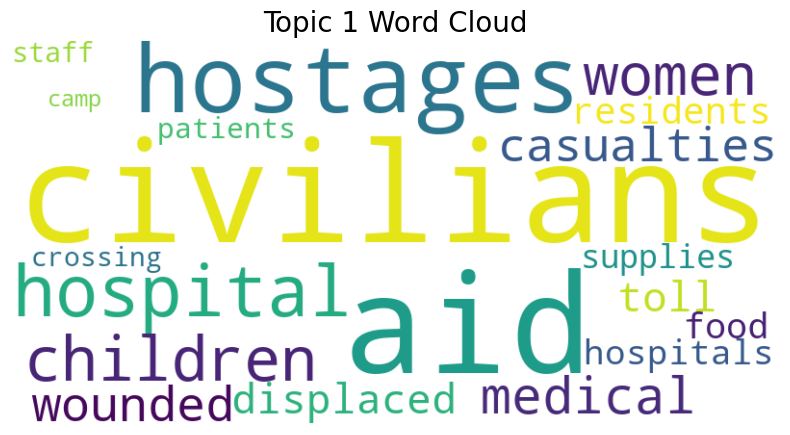

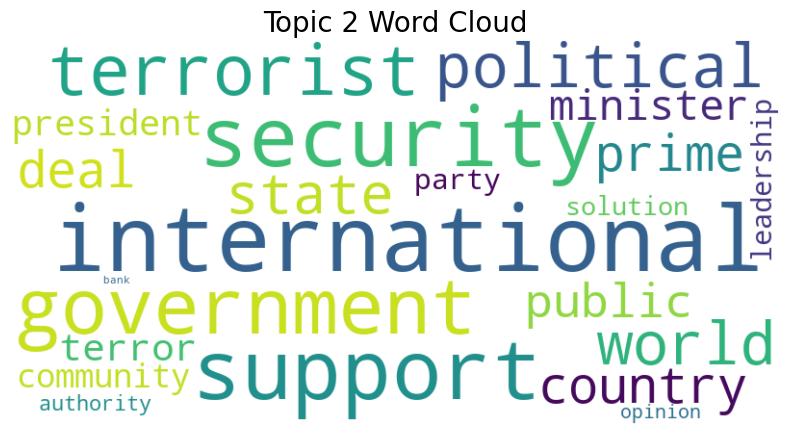

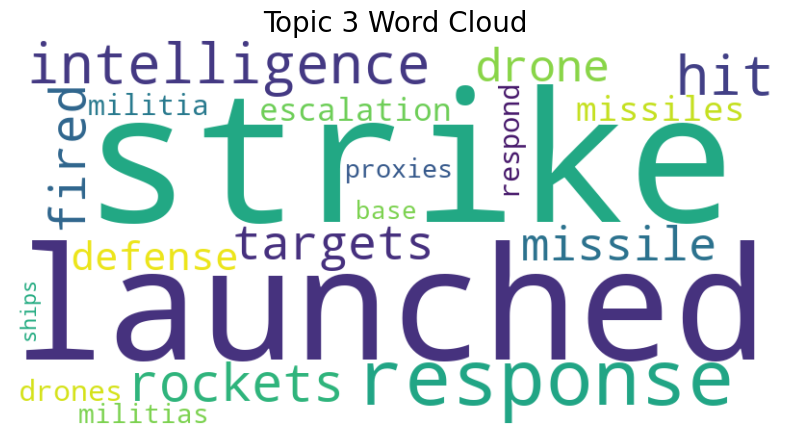

In [24]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud from word counts
def generate_wordcloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Generate and display word clouds for each topic
for i, topic_word_counts in enumerate(global_topic_word_counts_df.to_dict(orient='index').values()):
    generate_wordcloud(topic_word_counts, f"Topic {i + 1} Word Cloud")
